# Import Statements

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.ticker as mtick  
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTEENN


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


# Load Dataset

In [2]:
data = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv") 


In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.shape

(7043, 21)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
100*data['Churn'].value_counts()/len(data['Churn'])

Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64

dataset is imbalanced

In [8]:
data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

# Cleaning

In [9]:
df = data.copy()

In [10]:
df = df.drop(['customerID'], axis=1) 

In [11]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
# convert object to numeric values, if error it will convert it to NaN value

In [12]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

handelling the missing value

In [13]:
df.dropna(subset=['TotalCharges'], inplace=True)
print(data.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [14]:
print(df['tenure'].max())

72


highest value of tenure is 72, its better to divide it in ranges, 
so making a new column, range is 12 months, like 1-12 months, 13-24 months

In [15]:
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

df['tenure_group'] = pd.cut(df.tenure, range(1, 80, 12), right=False, labels=labels)

In [16]:
df['tenure_group'].value_counts()

tenure_group
1 - 12     2175
61 - 72    1407
13 - 24    1024
25 - 36     832
49 - 60     832
37 - 48     762
Name: count, dtype: int64

Now we have tenure grp column, we can
drop the old tenure column,

In [17]:
df = df.drop(['tenure'], axis=1) 

In [18]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


In [19]:
df["Churn"] = [1 if i=="Yes" else 0 for i in df["Churn"]]


In [20]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1 - 12


# Plots

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


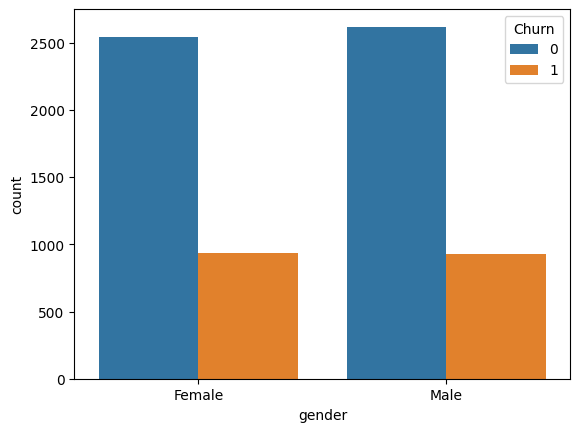

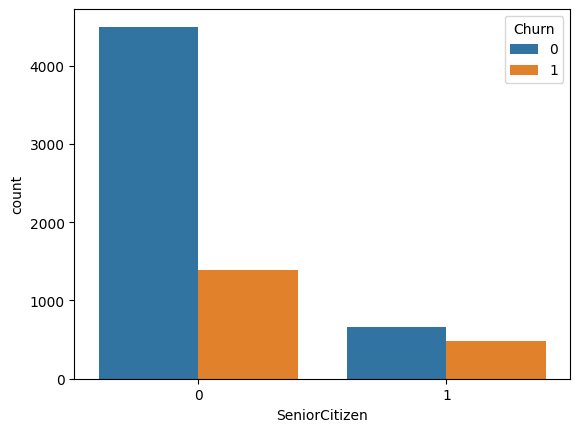

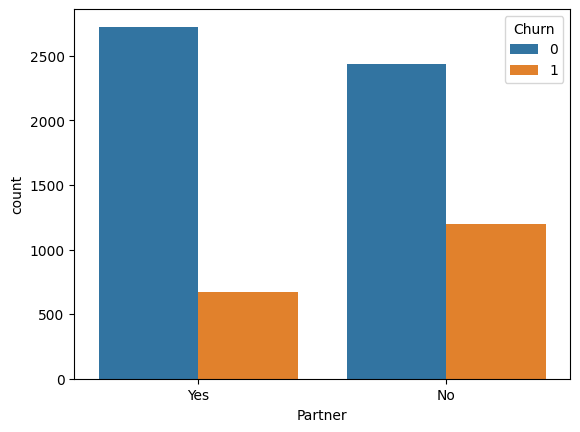

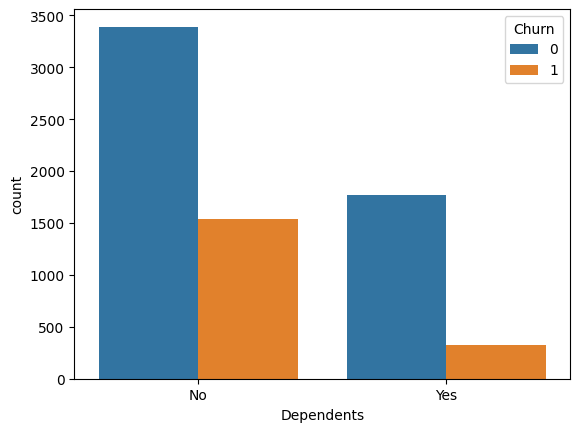

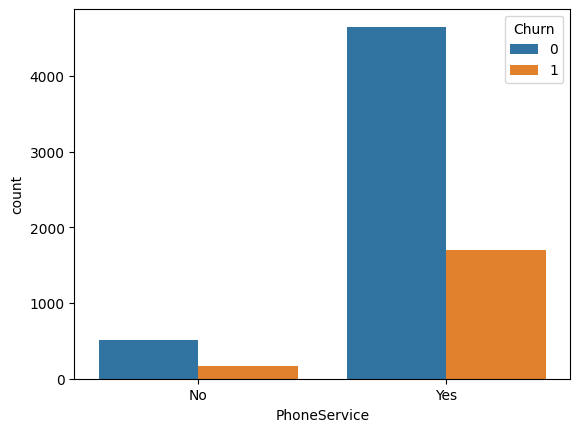

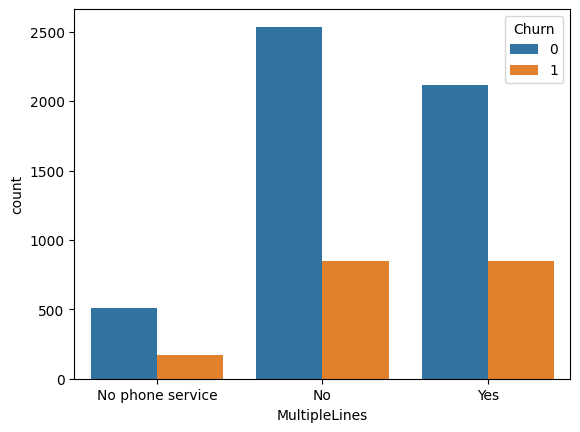

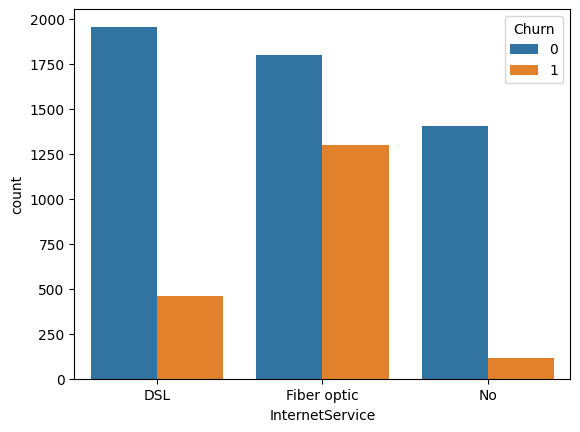

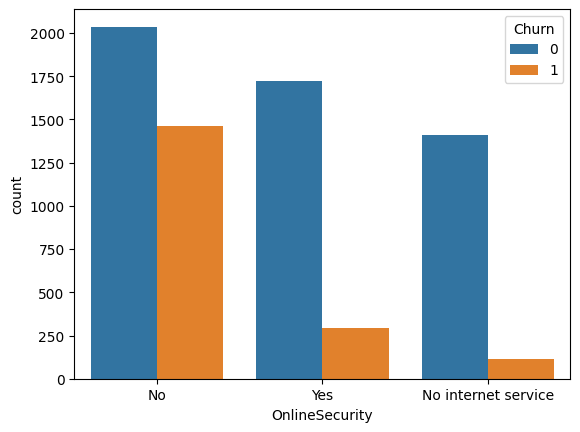

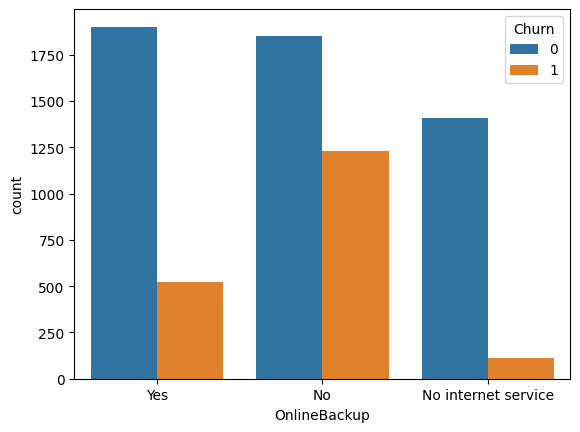

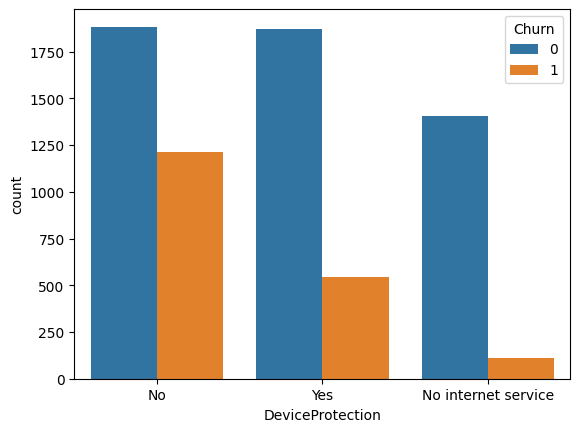

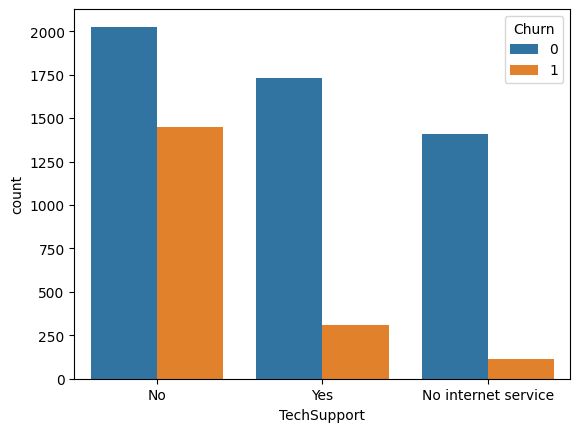

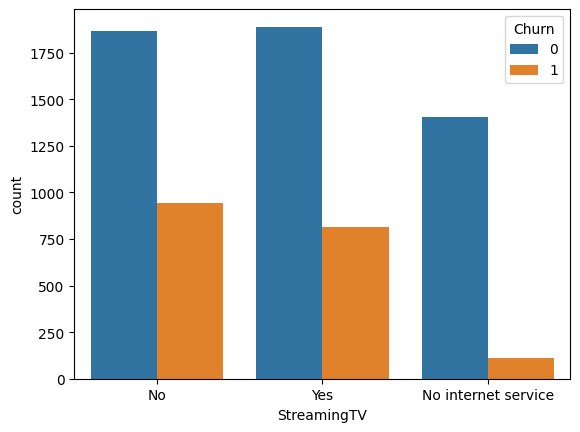

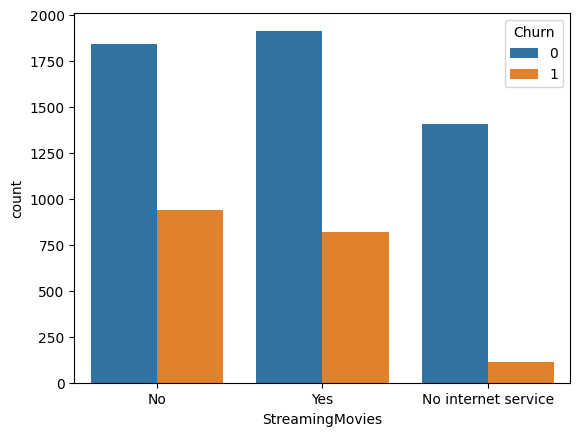

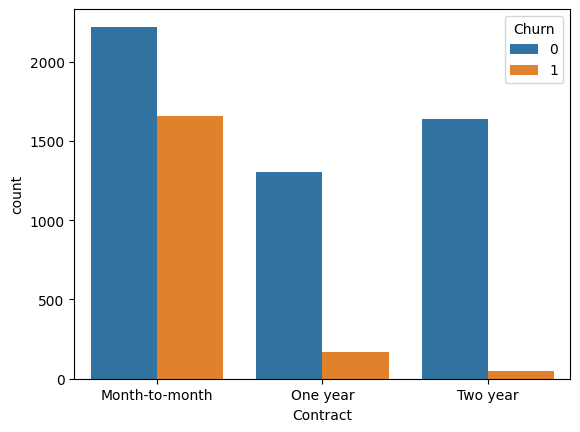

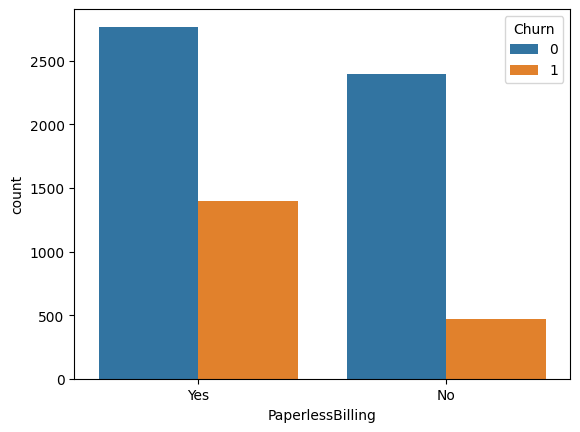

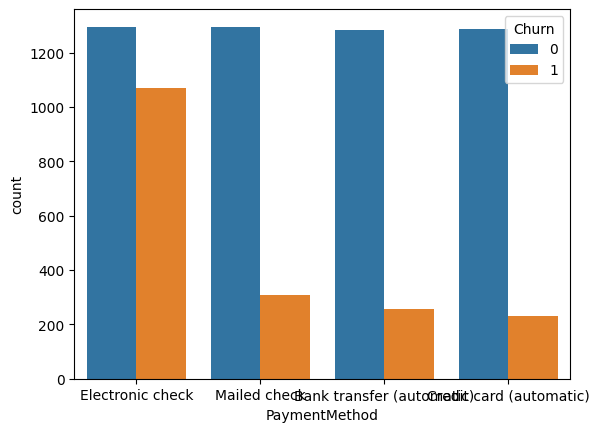

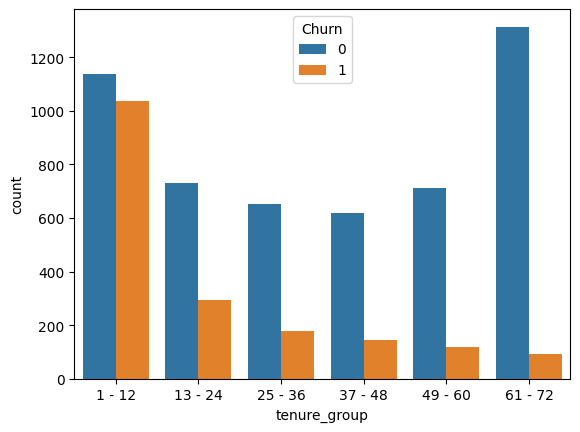

In [21]:
for i, predictor in enumerate(df.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=df, x=predictor, hue='Churn')

# One Hot Encoding for Categorical Variables

In [22]:
df_dummies = pd.get_dummies(df)


In [23]:
df_dummies.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,0,True,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
1,0,56.95,1889.50,0,False,True,True,False,True,False,...,False,False,False,True,False,False,True,False,False,False
2,0,53.85,108.15,1,False,True,True,False,True,False,...,False,False,False,True,True,False,False,False,False,False
3,0,42.30,1840.75,0,False,True,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
4,0,70.70,151.65,1,True,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,False


# Correlation

<Axes: >

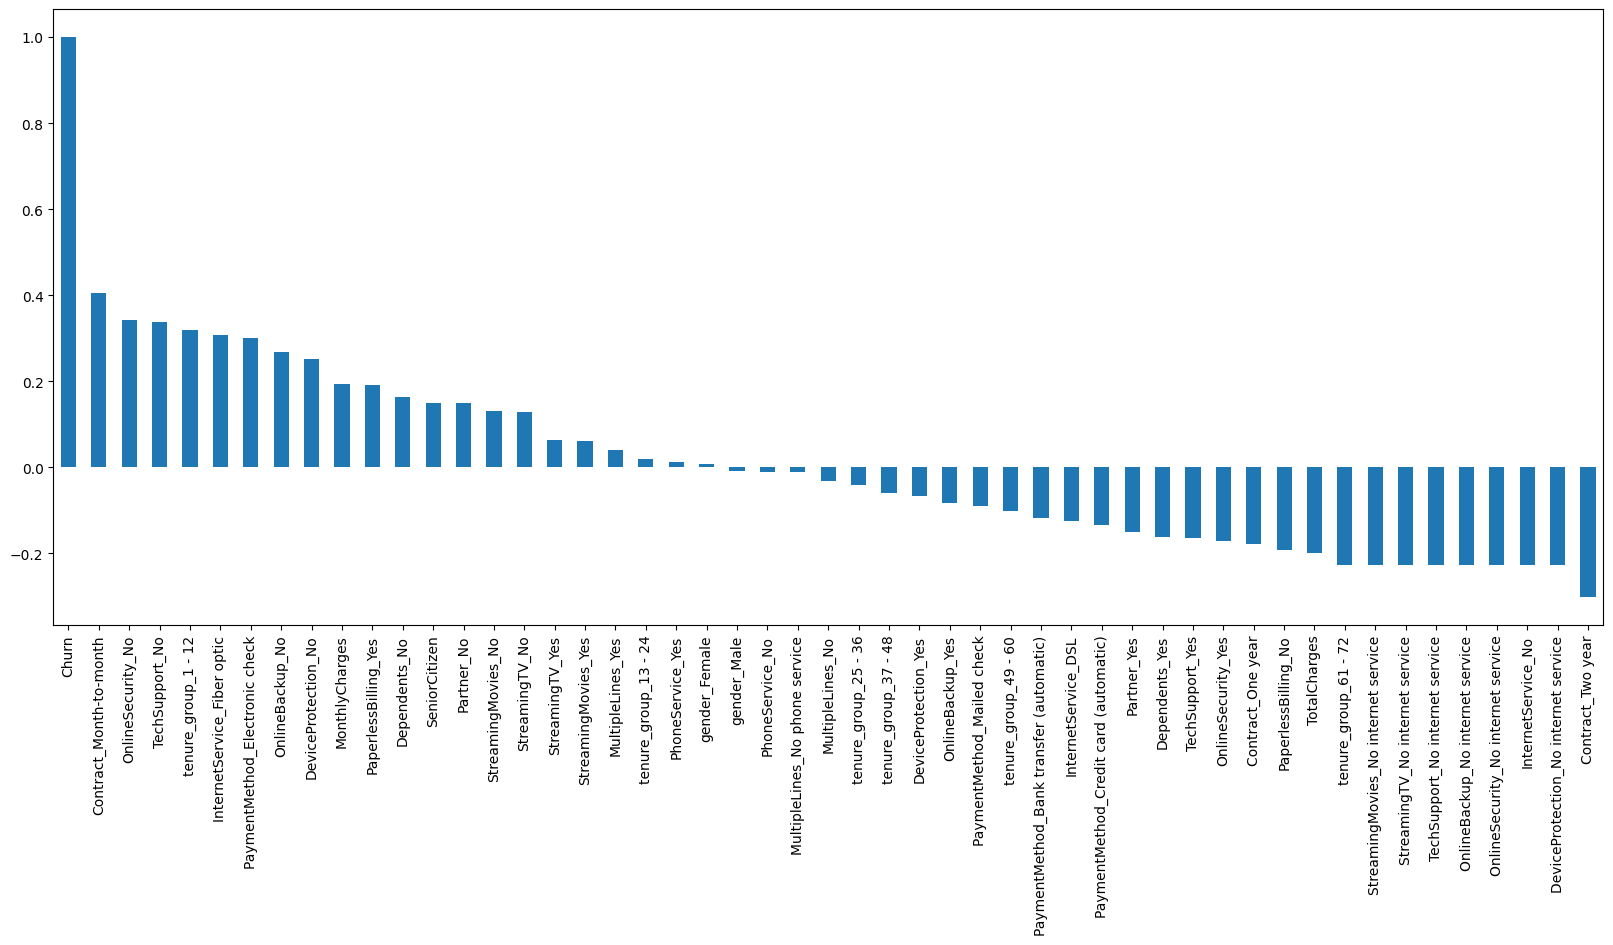

In [24]:
plt.figure(figsize=(20,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

# Some Insights

* People leaving more when they have month-to-month contracts.
* If there's no online security or tech support, customers are more likely to leave.
* People tend to stay longer when they have long-term contracts.
* If the subscription doesn't include internet, there's less chance of people leaving.
* New subscribers in their first year tend to stop using the service.
* Customers with fiber optics internet are more likely to leave.

In [25]:
df_dummies.to_csv('tel_churn_encoded.csv')

In [26]:
new_df = df_dummies.copy()

# Train Test Split

In [27]:
new_df.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,0,True,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
1,0,56.95,1889.50,0,False,True,True,False,True,False,...,False,False,False,True,False,False,True,False,False,False
2,0,53.85,108.15,1,False,True,True,False,True,False,...,False,False,False,True,True,False,False,False,False,False
3,0,42.30,1840.75,0,False,True,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
4,0,70.70,151.65,1,True,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,False


In [28]:
x=new_df.drop('Churn',axis=1)
x

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,True,False,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,False
1,0,56.95,1889.50,False,True,True,False,True,False,False,...,False,False,False,True,False,False,True,False,False,False
2,0,53.85,108.15,False,True,True,False,True,False,False,...,False,False,False,True,True,False,False,False,False,False
3,0,42.30,1840.75,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,True,False,False
4,0,70.70,151.65,True,False,True,False,True,False,False,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84.80,1990.50,False,True,False,True,False,True,False,...,False,False,False,True,False,True,False,False,False,False
7039,0,103.20,7362.90,True,False,False,True,False,True,False,...,False,True,False,False,False,False,False,False,False,True
7040,0,29.60,346.45,True,False,False,True,False,True,True,...,False,False,True,False,True,False,False,False,False,False
7041,1,74.40,306.60,False,True,False,True,True,False,False,...,False,False,False,True,True,False,False,False,False,False


In [29]:
y=df['Churn']
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int64

In [30]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25, random_state = 4)

# Trying Logistic Regression Model

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(random_state=42,max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [32]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [33]:
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.7952

Confusion Matrix:
[[1154  109]
 [ 251  244]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1263
           1       0.69      0.49      0.58       495

    accuracy                           0.80      1758
   macro avg       0.76      0.70      0.72      1758
weighted avg       0.78      0.80      0.78      1758



# Low accuracy because of Imbalanced dataset

* precision, recall and f1 score is okk for '0' that is 'not_churn'
* but not performing well on '1', because of imbalanced dataset
* as we have seen above
* Churn:-

*    No  ->   73.463013
*    Yes  ->  26.536987

# Using SMOTE to make the data balanced

In [34]:
from imblearn.combine import SMOTEENN

sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(x, y)


In [35]:
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.25)

In [36]:
model_sm = LogisticRegression(random_state=42,max_iter=1000)
model_sm.fit(xr_train, yr_train)
y_pred_sm = model_sm.predict(xr_test)

In [37]:
accuracy_lr = accuracy_score(yr_test, y_pred_sm)
conf_matrix_lr = confusion_matrix(yr_test, y_pred_sm)
classification_rep_lr = classification_report(yr_test, y_pred_sm)

# Got Better Accuracy with SMOTE

In [38]:
print(f"Accuracy: {accuracy_lr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_lr)
print("\nClassification Report:")
print(classification_rep_lr)

Accuracy: 0.9319

Confusion Matrix:
[[616  47]
 [ 54 766]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       663
           1       0.94      0.93      0.94       820

    accuracy                           0.93      1483
   macro avg       0.93      0.93      0.93      1483
weighted avg       0.93      0.93      0.93      1483



# Trying multiple Models

In [39]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = {
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(xr_train, yr_train)
    yr_pred = model.predict(xr_test)
    accuracy = accuracy_score(yr_test, yr_pred)
    classification_rep = classification_report(yr_test, yr_pred)
    conf_matrix = confusion_matrix(yr_test, yr_pred)
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Classification Report': classification_rep,
        'Confusion Matrix': conf_matrix
    }



In [40]:
results['Logistic Regression'] = {
    'Accuracy': accuracy_lr,
    'Classification Report': classification_rep_lr,
    'Confusion Matrix': conf_matrix_lr
}

In [41]:
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Classification Report:")
    print(result['Classification Report'])
    print("Confusion Matrix:")
    print(result['Confusion Matrix'])
    print("\n" + "="*50 + "\n")

Model: SVM
Accuracy: 0.7444
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.80      0.74       663
           1       0.81      0.70      0.75       820

    accuracy                           0.74      1483
   macro avg       0.75      0.75      0.74      1483
weighted avg       0.75      0.74      0.75      1483

Confusion Matrix:
[[530 133]
 [246 574]]


Model: Random Forest
Accuracy: 0.9528
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       663
           1       0.95      0.96      0.96       820

    accuracy                           0.95      1483
   macro avg       0.95      0.95      0.95      1483
weighted avg       0.95      0.95      0.95      1483

Confusion Matrix:
[[622  41]
 [ 29 791]]


Model: Gradient Boosting
Accuracy: 0.9474
Classification Report:
              precision    recall  f1-score   support

           0       0.94     

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


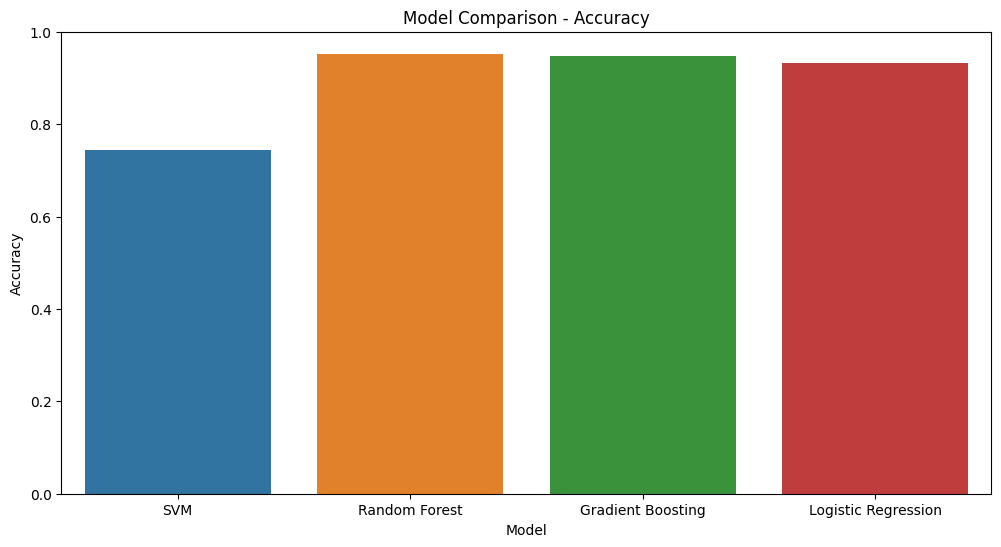

In [42]:
plt.figure(figsize=(12, 6))
sns.barplot(x=list(results.keys()), y=[result['Accuracy'] for result in results.values()])
plt.title('Model Comparison - Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Hyper parameter tuning

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_model = GradientBoostingClassifier()

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, verbose=1)

grid_search.fit(xr_train, yr_train)



Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [50]:
best_model = grid_search.best_estimator_

In [51]:
y_pred_test = best_model.predict(xr_test)
accuracy_test = accuracy_score(yr_test, y_pred_test)

In [52]:
print("Accuracy: ", accuracy_test)
print("Confusion Matrix:\n", confusion_matrix(yr_test, y_pred_test))
print("\nClassification Report:\n", classification_report(yr_test, y_pred_test))

Accuracy:  0.9581928523263655
Confusion Matrix:
 [[630  33]
 [ 29 791]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       663
           1       0.96      0.96      0.96       820

    accuracy                           0.96      1483
   macro avg       0.96      0.96      0.96      1483
weighted avg       0.96      0.96      0.96      1483



In [53]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, verbose=1)
grid_search_rf.fit(xr_train, yr_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [54]:
best_model_r = grid_search.best_estimator_

In [55]:
y_pred_test_r = best_model_r.predict(xr_test)
accuracy_test_r = accuracy_score(yr_test, y_pred_test_r)

In [56]:
print("Accuracy: ", accuracy_test)
print("Confusion Matrix:\n", confusion_matrix(yr_test, y_pred_test_r))
print("\nClassification Report:\n", classification_report(yr_test, y_pred_test_r))

Accuracy:  0.9581928523263655
Confusion Matrix:
 [[630  33]
 [ 29 791]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       663
           1       0.96      0.96      0.96       820

    accuracy                           0.96      1483
   macro avg       0.96      0.96      0.96      1483
weighted avg       0.96      0.96      0.96      1483



# TO save the models

In [ ]:
# to save model
# import joblib
# best_model_name = max(results, key=lambda k: results[k]['Accuracy'])
# best_model = models[best_model_name]
# joblib.dump(best_model, f'{best_model_name}_model.joblib')
# results.pop(best_model_name)  
# second_best_model_name = max(results, key=lambda k: results[k]['Accuracy'])
# second_best_model = models[second_best_model_name]
# joblib.dump(second_best_model, f'{second_best_model_name}_model.joblib')


In [ ]:
# loaded_best_model = joblib.load('/kaggle/working/Gradient Boosting_model.joblib')
# loaded_second_best_model = joblib.load('/kaggle/working/Random Forest_model.joblib')

In [ ]:
# acc_boost = loaded_best_model.predict(xr_test)
# acc_random = loaded_second_best_model.predict(xr_test)

In [ ]:
# print(f"Gradient_boost: {accuracy_score(yr_test, acc_boost)}")
# print(f"Gradient_boost: {accuracy_score(yr_test, acc_random)}")

# Trying Neural Network

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score
# from keras.callbacks import EarlyStopping

using kfold for model validation

In [ ]:
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# accuracy_scores = []
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# for train_index, test_index in kf.split(X_resampled, y_resampled):
#     X_train_fold, X_test_fold = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
#     y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

#     scaler = StandardScaler()
#     X_train_fold_scaled = scaler.fit_transform(X_train_fold)
#     X_test_fold_scaled = scaler.transform(X_test_fold)

#     model = Sequential()
#     model.add(Dense(units=20, activation='relu', input_dim=X_resampled.shape[1]))
#     model.add(Dense(units=10, activation='relu'))
#     model.add(Dense(units=5, activation='relu'))
#     model.add(Dense(units=1, activation='sigmoid'))
    
#     model.compile(optimizer='adam', 
#                   loss='binary_crossentropy', 
#                   metrics=['accuracy'])

#     model.fit(
#         X_train_fold_scaled, y_train_fold,
#         epochs=25, batch_size=16,
#         validation_data=(X_test_fold_scaled, y_test_fold),
#         callbacks=[early_stopping],
#         verbose=1
#     )

#     y_pred_fold_prob = model.predict(X_test_fold_scaled)
#     y_pred_fold = (y_pred_fold_prob > 0.5).astype(int)
#     accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
#     accuracy_scores.append(accuracy_fold)

In [ ]:
# average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
# print(f"Average accuracy across folds: {average_accuracy:.4f}")